# Tomography

Tomography aims to reconstruct a quantity of interest $f$ using line-integral evaluations of $f$.

In [1]:
import torch
import math

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['figure.figsize'] = [5,5]

import numpy as np

## Define experiment

The following ``CircleExperiment`` implements evaluating line integrals of the quantity of interest using a Riemann sum as well as a bunch of helper and plotting functions.

In [2]:
from gaussed.solver.integral_transform.riemann_sum import RiemannSum
from gaussed.transforms.linear import LineIntegral

class CircleExperiment:
    
    def __init__(self, c, r, n=5, d=0.02, domain=torch.Tensor([[-1,1],[-1,1]])):
        self.c = c
        self.r = r
        
        self.n = n
        self.d = d
        self.domain = domain

    def eval(self, x):
        x1,x2 = x.T
        out = ((x1 - self.c[0]) ** 2 + (x2 - self.c[1]) ** 2 < self.r ** 2).float()
        return out
    
    @staticmethod
    def get_integral_limits(domain, theta, x, y):
        L_x, U_x = domain[0]
        L_y, U_y = domain[1]

        if 0 <= theta % (2 * math.pi) < math.pi/2:
            lower = torch.max((L_x - x) / torch.cos(theta), (L_y - y) / torch.sin(theta))
            upper = torch.min((U_x - x) / torch.cos(theta), (U_y - y) / torch.sin(theta))
        elif math.pi/2 <= theta % (2 * math.pi) < math.pi:
            lower = torch.max((U_x - x) / torch.cos(theta), (L_y - y) / torch.sin(theta))
            upper = torch.min((L_x - x) / torch.cos(theta), (U_y - y) / torch.sin(theta))
        elif math.pi <= theta % (2 * math.pi) < 3 * math.pi / 2:
            lower = torch.max((U_x - x) / torch.cos(theta), (U_y - y) / torch.sin(theta))
            upper = torch.min((L_x - x) / torch.cos(theta), (L_y - y) / torch.sin(theta))
        else:
            lower = torch.max((L_x - x) / torch.cos(theta), (U_y - y) / torch.sin(theta))
            upper = torch.min((U_x - x) / torch.cos(theta), (L_y - y) / torch.sin(theta))
            
        volume = upper-lower
        
        return lower, upper, volume 
    
    @staticmethod
    def line_func(s, theta, x, y):
        return s.unsqueeze(1) * torch.stack([torch.cos(theta),torch.sin(theta)]).T + torch.stack([x, y]).T
    
    
    def experiment(self, param, mesh_fineness=200): 
        theta, x, y = param
        d = self.d

        x_init = x - (self.n-1)/2 * d * torch.sin(theta)
        y_init = y + (self.n-1)/2 * d * torch.cos(theta)
        x_intercepts = [x_init + i * d * torch.sin(theta) for i in range(self.n)]
        y_intercepts = [y_init - i * d * torch.cos(theta) for i in range(self.n)]

        line_integral_list = [] 
        
        for i in range(self.n):
            lower, upper, volume = self.get_integral_limits(self.domain, theta, x_intercepts[i], y_intercepts[i])

            mesh_i = torch.linspace(lower[0], upper[0], mesh_fineness)
            out = volume * torch.mean(self.eval(self.line_func(mesh_i, theta, x_intercepts[i], y_intercepts[i])))
            line_integral_list.append(out)
        
        return torch.Tensor(line_integral_list)
    
    def single_experiment(self, param, mesh_fineness=200): 
        theta, x, y = param
        d = self.d

        lower, upper, volume = self.get_integral_limits(self.domain, theta, x, y)

        mesh = torch.linspace(lower[0],upper[0],mesh_fineness)
        out = volume * torch.mean(self.eval(self.line_func(mesh, theta, x, y)))
        return out
    
    def get_line_int_gps(self, param, gp, mesh_fineness=150):
        d = self.d
        theta, x, y = param
        x_init = x - (self.n-1)/2 * d * torch.sin(theta)
        y_init = y + (self.n-1)/2 * d * torch.cos(theta)
        x_intercepts = [x_init + i * d * torch.sin(theta) for i in range(self.n)]
        y_intercepts = [y_init - i * d * torch.cos(theta) for i in range(self.n)]
        
        gp_list = []
        rs = []

        for i in range(self.n):
            def r(x, i=i):
                return CircleExperiment.line_func(x, theta, x_intercepts[i], y_intercepts[i])
            rs.append(r)

            method = self.get_integral_method([theta,x_intercepts[i],y_intercepts[i]], mesh_fineness=mesh_fineness)

            gp_list.append(LineIntegral(gp, rs[i], method, add_id=False)())
            
        return gp_list
    
    def get_integral_method(self, param, mesh_fineness=50):
        theta, x, y = param
        l,u,vol = CircleExperiment.get_integral_limits(self.domain, theta, x, y)
        mesh = torch.linspace(l[0].detach(), u[0].detach(), mesh_fineness)

        return RiemannSum(mesh, vol)
        
    def plot_experiment(self, param, mesh_fineness=1000):
             
        xs = torch.linspace(self.domain[0][0], self.domain[0][1], mesh_fineness)
        ys = torch.linspace(self.domain[1][0], self.domain[1][1], mesh_fineness)
        mesh = torch.stack(torch.meshgrid(xs,ys)).T
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        circ_data = self.eval(mesh)
        
        ax.imshow(circ_data.T,interpolation="gaussian",extent=(self.domain[0][0],self.domain[0][1],self.domain[1][0],self.domain[1][1]),origin="lower",cmap="Reds")
        if param is not None:
            self.plot_experiment_lines(ax, param)
        
        return ax
    
    def get_intercepts(self, domain, theta, x, y):
        
        l,u,_ = self.get_integral_limits(domain, theta, x, y)
        xx_l, yy_l = self.line_func(l, theta, x, y)[0]
        xx_u, yy_u = self.line_func(u, theta, x, y)[0]
        
        if xx_u < xx_l:
            x_l, x_u, y_l, y_u = xx_u, xx_l, yy_u, yy_l
        else:
            x_l, x_u, y_l, y_u = xx_l, xx_u, yy_l, yy_u
            
        return x_l, y_l, x_u, y_u
        
    def plot_experiment_lines(self, ax, param, color="red", print_theta=False, sparse=True, noline=False, alpha=0.1):
        d = self.d
        theta, x, y = param

        x_init = x - (self.n-1)/2 * d * torch.sin(theta)
        y_init = y + (self.n-1)/2 * d * torch.cos(theta)
        x_intercepts = [x_init + i * d * torch.sin(theta) for i in range(self.n)]
        y_intercepts = [y_init - i * d * torch.cos(theta) for i in range(self.n)]

        if sparse is not True:
            for i in range(self.n):
                l,u,_ = self.get_integral_limits(self.domain, theta, x_intercepts[i], y_intercepts[i])

                if print_theta is True:
                    print("θ, x, y: ", theta, x_intercepts[i], y_intercepts[i])
                    print("l, u, vol: ", l,u,_)

                lin_mesh = torch.linspace(l[0],u[0],2)
                line_i = self.line_func(lin_mesh, theta, x_intercepts[i], y_intercepts[i])
                ax.plot(line_i.T[0],line_i.T[1],color=color)

            ax.scatter(torch.Tensor(x_intercepts).flatten(),torch.Tensor(y_intercepts).flatten(),color=color)
        
        else:
            l1,u1,_ = self.get_integral_limits(self.domain, theta, x_intercepts[0], y_intercepts[0])
            lin_mesh1 = torch.linspace(l1[0],u1[0],2)
            line_1 = self.line_func(lin_mesh1, theta, x_intercepts[0], y_intercepts[0])
            if noline is False:
                ax.plot(line_1.T[0],line_1.T[1],color=color,ls="-",lw=0.05)
            
            l2,u2,_ = self.get_integral_limits(self.domain, theta, x_intercepts[-1], y_intercepts[-1])
            lin_mesh2 = torch.linspace(l2[0],u2[0],2)
            line_2 = self.line_func(lin_mesh2, theta, x_intercepts[-1], y_intercepts[-1])
            if noline is False:
                ax.plot(line_2.T[0],line_2.T[1],color=color,ls="-",lw=0.05)

            x_l1, y_l1, x_u1, y_u1 = self.get_intercepts(self.domain, theta, x_intercepts[0], y_intercepts[0])
            x_l2, y_l2, x_u2, y_u2 = self.get_intercepts(self.domain, theta, x_intercepts[-1], y_intercepts[-1])
            
            domain_xl, domain_xu = self.domain[0]
            domain_yl, domain_yu = self.domain[1]
            
            if theta == math.pi/2:
                ax.fill_betweenx(torch.linspace(y_l1, y_u1, 2), torch.Tensor([x_l1, x_u1]), torch.Tensor([x_l2, x_u2]), color="red",alpha=alpha)
            else:
                y_ll1 = torch.tan(theta) * (x_l2 - x_l1) + y_l1
                y_uu2 = torch.tan(theta) * (x_u1 - x_l2) + y_l2
                y_l_list = np.maximum(np.minimum(torch.Tensor([y_l1, y_ll1, y_u1, y_u1]).numpy(),[domain_yu,domain_yu,domain_yu,domain_yu]),[domain_yl,domain_yl,domain_yl,domain_yl])
                y_u_list = np.maximum(np.minimum(torch.Tensor([y_l2, y_l2, y_uu2, y_u2]).numpy(),[domain_yu,domain_yu,domain_yu,domain_yu]),[domain_yl,domain_yl,domain_yl,domain_yl])
                ax.fill_between([x_l1, x_l2, x_u1, x_u2], torch.Tensor([y_l1, y_ll1, y_u1, y_u1]), torch.Tensor([y_l2, y_l2, y_uu2, y_u2]), color="red",alpha=alpha)
                
        ax.set_ylim(-1,1)
        ax.grid(False)
        
    def plot_single_experiments(self, thetas, x, y, mesh_fineness=1000): 
        xs = torch.linspace(self.domain[0][0], self.domain[0][1], mesh_fineness)
        ys = torch.linspace(self.domain[1][0], self.domain[1][1], mesh_fineness)
        mesh = torch.stack(torch.meshgrid(xs,ys)).T
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        circ_data = self.eval(mesh)
        
        ax.imshow(circ_data.T,interpolation="gaussian",extent=(self.domain[0][0],self.domain[0][1],self.domain[1][0],self.domain[1][1]),origin="lower",cmap="Reds")
        
        for i in range(len(thetas)):
            l,u,_ = self.get_integral_limits(self.domain, thetas[i], x[i], y[i])

            lin_mesh = torch.linspace(l[0],u[0],2)
            line_i = self.line_func(lin_mesh,thetas[i], x[i], y[i])
            ax.plot(line_i.T[0],line_i.T[1],color="red")
            
        ax.grid(False)
        plt.scatter(x.flatten(),y.flatten())
        
        plt.show()

## Define GP and its transformation

In [3]:
from gaussed.distribution import SpectralGP
from gaussed.kernel import MaternKernel
from gaussed.transforms.nonlinear import OutputWarp

domain = [[-1.05,1.05],[-1.05,1.05]]
initial_parameters = [torch.Tensor([0.3]).requires_grad_(True), torch.Tensor([0.4]).requires_grad_(True)]

k = MaternKernel(2, 2, initial_parameters)
gp = SpectralGP(k)
gp.set_domain(domain)

exponential_warp = lambda x: torch.exp(3 * x)
qoi = OutputWarp(gp, exponential_warp)()

## Define Experiment Setup

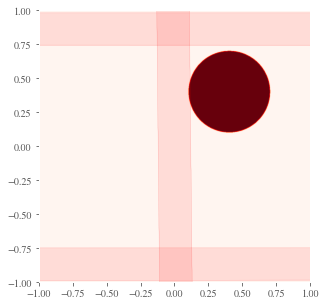

In [4]:
circ = CircleExperiment(torch.Tensor([0.4,0.4]),0.3,9,0.03,domain=torch.Tensor([[-1,1],[-1,1]]))
param = [torch.Tensor([math.pi/4]), torch.Tensor([0])]

param = torch.Tensor([[math.pi/2+0.01], [0], [0]])
AX = circ.plot_experiment(param,1000)

thetas = torch.linspace(-10,10,2).unsqueeze(1) + 1
for i in thetas:
    param = torch.Tensor([[i[0]], [i[0]], [i[0]]])
    param[0] = torch.sigmoid(param[0]) * math.pi
    param[1:] = (2 - circ.n * circ.d) * torch.sigmoid(param[1:]) - 1 + circ.n * circ.d / 2
    circ.plot_experiment_lines(AX,param)
plt.show()

## Plotting a sample from the prior of the QoI

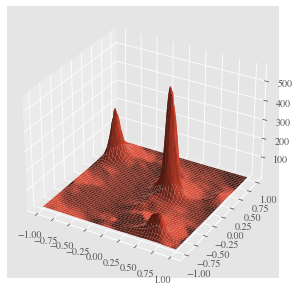

In [5]:
torch.manual_seed(10)

x_2D = torch.linspace(-1,1,200)
y_2D = torch.linspace(-1,1,200)
X_2D,Y_2D = torch.meshgrid(x_2D,y_2D)

prior_funcs_1D = qoi.sample_prior(2,30)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X_2D.numpy(), Y_2D.numpy(), prior_funcs_1D(torch.stack([X_2D,Y_2D]).T.reshape(X_2D.shape[0]**2,2)).T[1].reshape(200,200).T.detach().numpy())
plt.show()

## Define Experiment

In [6]:
from gaussed.experiment import Design, Experiment, L2
from gaussed.experiment.bayes_risk import BayesRiskMatheron

x = torch.linspace(-1,1,25)
y = torch.linspace(-1,1,25)
X,Y = torch.meshgrid(x,y)
mesh_2D = torch.stack([X,Y]).T.reshape(X.shape[0]**2,2)

loss_warp = L2(qoi, mesh_2D, use_mesh=True)

def design_transform(design):
    d_lower = torch.Tensor([0, - 1 + circ.n * circ.d / 2, - 1 + circ.n * circ.d / 2])
    d_upper = torch.Tensor([math.pi, 1 - circ.n * circ.d / 2, 1 - circ.n * circ.d / 2])
    return d_lower + (d_upper - d_lower) * torch.sigmoid(design)

def d_func(design, m):
    all_phis = []
    D = design_transform(design)
    for i in range(len(D)):
        design_i = D[i]
        line_int_gps = circ.get_line_int_gps(design_i.unsqueeze(1), qoi)
        for j in line_int_gps:
            all_phis.append(j.basis_matrix(None,m))
    return torch.cat(all_phis)
        
def d_sample(design_point, mean, cov, n, random_sample=None, solver=None):
    all_samples = []
    
    line_int_gps = circ.get_line_int_gps(design_transform(design_point).unsqueeze(1), qoi)
    
    if solver is None:
        matrix_sqrt = qoi.solver.square_root(cov)
    else:
        matrix_sqrt = solver.square_root(cov)
    
    for i in line_int_gps:
        samp_i = i.sample(mean, cov, n, random_sample, solver, matrix_sqrt)(None)
        all_samples.append(samp_i)
    
    return torch.cat(all_samples).T
    
def matheron_sampler(design_point, phi_mat, y, n, random_sample=None, solver=None, nugget=None, inverse=None):
    all_samples = []
    
    line_int_gps = circ.get_line_int_gps(design_transform(design_point).unsqueeze(1), qoi)
    
    for i in line_int_gps:
        samp_i = i.matheron_sample(phi_mat, y, n, random_sample, solver, inverse)(None)
        all_samples.append(samp_i)
    
    return torch.cat(all_samples).T

def sample_domain(N=None):
    d_lower = torch.Tensor([0, - 1 + circ.n * circ.d / 2, - 1 + circ.n * circ.d / 2])
    d_upper = torch.Tensor([math.pi, 1 - circ.n * circ.d / 2, 1 - circ.n * circ.d / 2])
    
    if N is None:
        u = torch.distributions.Uniform(d_lower, d_upper).sample((1,))
        return (torch.log((u - d_lower) / (d_upper - d_lower)) - torch.log(1 - (u - d_lower) / (d_upper - d_lower))).flatten()
    else: 
        u = torch.distributions.Uniform(d_lower, d_upper).sample((N,))
        return (torch.log((u - d_lower) / (d_upper - d_lower)) - torch.log(1 - (u - d_lower) / (d_upper - d_lower)))
    
def transformed_black_box(design_point):
    D = design_point.detach().clone()
    if D.dim() == 1:
        D = D.unsqueeze(0)
    output = []
    for i in D:
        Di = i
        Di[0] = math.pi * torch.sigmoid(Di[0])
        Di[1:] = (2 - circ.n * circ.d) * torch.sigmoid(Di[1:]) - 1 + circ.n * circ.d / 2
        Di = Di.unsqueeze(1)
        output.append(circ.experiment(Di, 900))
        
    return torch.cat(output)

def inverse_design_transform1(design):
    d_lower = torch.Tensor([0, - 1 + circ.n * circ.d / 2, - 1 + circ.n * circ.d / 2])
    d_upper = torch.Tensor([math.pi, 1 - circ.n * circ.d / 2, 1 - circ.n * circ.d / 2])
    return (torch.log((design - d_lower) / (d_upper - d_lower)) - torch.log(1 - (design - d_lower) / (d_upper - d_lower)))


initial_design = torch.Tensor([[0,  0,  0]])
d = Design(d_func, d_sample, initial_design = initial_design, sample_domain=sample_domain, matheron_sampler=matheron_sampler)
acq = BayesRiskMatheron(qoi, loss_warp, d, nugget=1e-2)
experiment = Experiment(qoi, transformed_black_box, d, acq, m=28)

experiment.acq_optim.N = 400
experiment.start_hyp_optimising_step = 5

## Run Experiment

In [ ]:
torch.manual_seed(12)

experiment.run(30)

## Plot Output

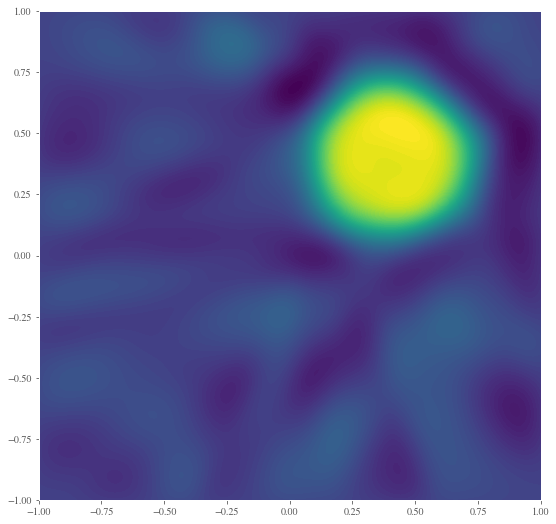

In [25]:
phi_mat = d_func(experiment.current_design, 30)

mean, covariance = gp.condition(phi_mat, experiment.data, nugget=1e-4)

mean_function = qoi.get_mean(mean) 

y = torch.linspace(-1,1,550)
x = torch.linspace(-1,1,550)
X,Y = torch.meshgrid(x,y)

Z = mean_function(torch.stack([X,Y]).T.reshape(X.shape[0]**2,2)).reshape(550,550).T

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)

ax.contourf(X.numpy(), Y.numpy(), Z.detach().numpy(), levels=100)
plt.show()

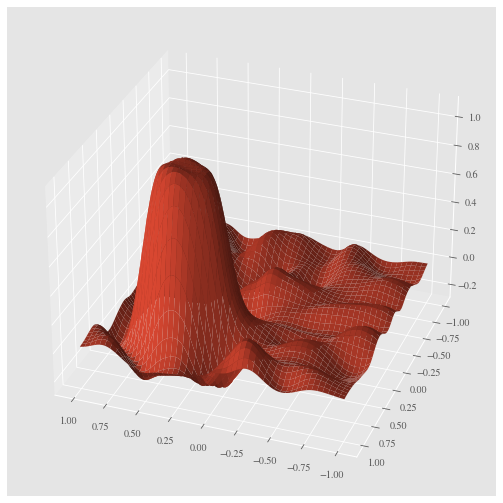

In [26]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30., azim=110)

ax.plot_surface(X.numpy(),Y.numpy(), Z.detach().numpy())
plt.show()